In [1]:
import torch 

from Datasets import *
import os
from torch.autograd import Variable

from model_generator import *

import numpy as np
import torch.optim as optim
#from kcrf.estimator import simple_estimator as np_simple_est
from Utils import * 
from viz_utils import *
import time 
import matplotlib.pyplot as plt
%matplotlib inline

ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
use_cuda = True
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128
# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64
# Number of channels in the training images. For color images this is 3
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64
# Number of training epochs
num_epochs = 5
# Learning rate for optimizers
lr = 0.002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [ ]:

torch.manual_seed(999)
num_particles = 1000
# Target
D = 2
center_target = 0.
sigma_target = 1.
target = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(D ,dtype=torch.float32,device=device), torch.eye(D,dtype=torch.float32,device=device))
target = target_wrapper(target, dtype = torch.float32, device = device)
#target = GaussianGenerator(target,center_target,sigma_target,D).to(device)
#target = ParticleGenerator(target,num_particles)


# Initializing particles
center = 10.
sigma = .5

base = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(D ,dtype=torch.float32,device=device), torch.eye(D,dtype=torch.float32,device=device))
base = target_wrapper(base, dtype = torch.float32, device = device)
base = GaussianGenerator(base,center,sigma,D).to(device)
particles = ParticleGenerator(base,num_particles)

# Building loss
bandwidth = 2.
d_out = D
Loss = PlainMMD(bandwidth, d_out,use_cuda).to(device)
torch.manual_seed(999)

lr = 1.*num_particles
optimizerD = None
optimizerG = optim.SGD(particles.parameters(), lr=lr)
init_data = witness_wrapper(Loss,target,particles)
out = train(Loss,optimizerG, optimizerD,particles, target, base_distribution = None , device=device,generator_steps = 100,learn_critic= False,b_size = 1000,save_particles=True)
final_data = witness_wrapper(Loss,target,particles)



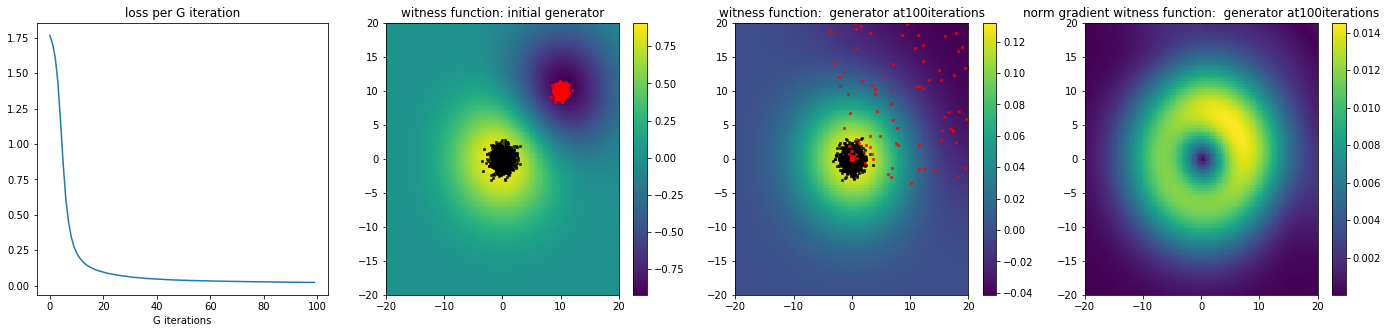

In [24]:
plot_witness_loss(out["G_losses"],init_data,final_data,  net="G", method = "", num_final_it = 100)







In [25]:

torch.manual_seed(999)
num_particles = 1000
# Target
D = 2
center_target = 0.
sigma_target = 1.
target = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(D ,dtype=torch.float32,device=device), torch.eye(D,dtype=torch.float32,device=device))
target = target_wrapper(target, dtype = torch.float32, device = device)
#target = GaussianGenerator(target,center_target,sigma_target,D).to(device)
#target = ParticleGenerator(target,num_particles)


# Initializing particles
center = 2.
sigma = .5

base = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(D ,dtype=torch.float32,device=device), torch.eye(D,dtype=torch.float32,device=device))
base = target_wrapper(base, dtype = torch.float32, device = device)
base = GaussianGenerator(base,center,sigma,D).to(device)
particles = ParticleGenerator(base,num_particles)

# Building loss
bandwidth = 2.
d_out = D
Loss = PlainMMD(bandwidth, d_out,use_cuda).to(device)
torch.manual_seed(999)

lr = 1.*num_particles
optimizerD = None
optimizerG = optim.SGD(particles.parameters(), lr=lr)
init_data = witness_wrapper(Loss,target,particles)
out = train(Loss,optimizerG, optimizerD,particles, target, base_distribution = None , device=device,generator_steps = 1000,learn_critic= False,b_size = 100,save_particles=True)
final_data = witness_wrapper(Loss,target,particles)



Starting Training Loop...


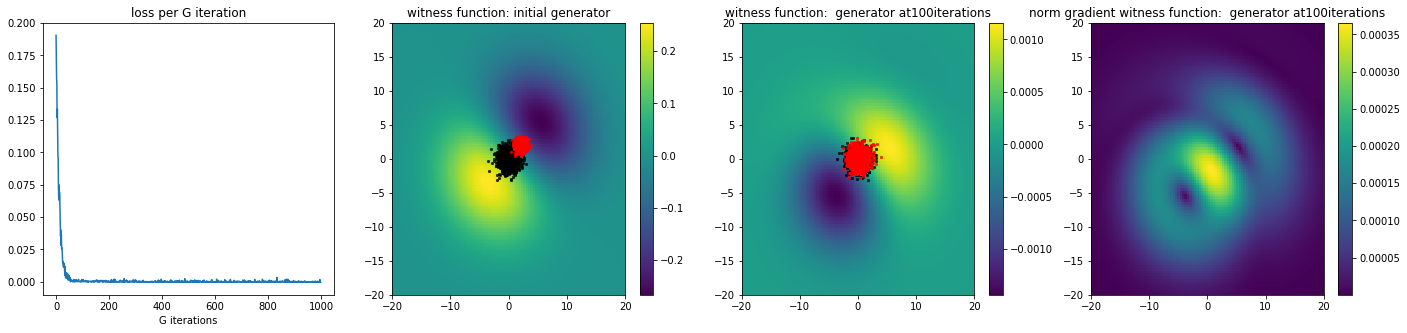

In [26]:
plot_witness_loss(out["G_losses"],init_data,final_data,  net="G", method = "", num_final_it = 100)


In [ ]:
torch.manual_seed(999)
num_particles = 1000
# Target
D = 2
center_target = 0.
sigma_target = 1.
target = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(D ,dtype=torch.float32,device=device), torch.eye(D,dtype=torch.float32,device=device))
target = target_wrapper(target, dtype = torch.float32, device = device)
#target = GaussianGenerator(target,center_target,sigma_target,D).to(device)
#target = ParticleGenerator(target,num_particles)


# Initializing particles
center = 10.
sigma = .5

base = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(D ,dtype=torch.float32,device=device), torch.eye(D,dtype=torch.float32,device=device))
base = target_wrapper(base, dtype = torch.float32, device = device)
base = GaussianGenerator(base,center,sigma,D).to(device)
particles = ParticleGenerator(base,num_particles)

# Building loss
H = 4
d_out = 1
Loss = ScaledMMD( D,H, d_out,use_cuda).to(device)
torch.manual_seed(999)

lr = 1.*num_particles
lr_critic = 0.0002
optimizerD = optim.Adam(Loss.parameters(), lr=lr_critic, betas=(beta1, 0.999))
optimizerG = optim.SGD(particles.parameters(), lr=lr)
init_data = witness_wrapper(Loss,target,particles)
out = train(Loss,optimizerG, optimizerD,particles, target, base_distribution = target , device=device,generator_steps = 1,learn_critic= True,critic_steps = 100,b_size = 100,save_particles=True)
out = train(Loss,optimizerG, optimizerD,particles, target, base_distribution = target , device=device,generator_steps = 1000,learn_critic= True,critic_steps = 10,b_size = 100,save_particles=True)

final_data = witness_wrapper(Loss,target,particles)


Starting Training Loop...
Starting Training Loop...


In [ ]:
plot_witness_loss(out["G_losses"],init_data,final_data,  net="G", method = "", num_final_it = 100)


In [27]:

def plot_particles(axes,out):
    num_iteration = len(out["particles"])
    assert len(axes)==num_iteration+1
    for j in range(num_iteration):
        axes[j].scatter(out["particles"][j][:,0],out["particles"][j][:,1],color= "r")
        axes[0].set_title( str(out["particles_iter"][j]))
    axes[-1].scatter(out["target_particles"][:,0],out["target_particles"][:,1],color= "g")


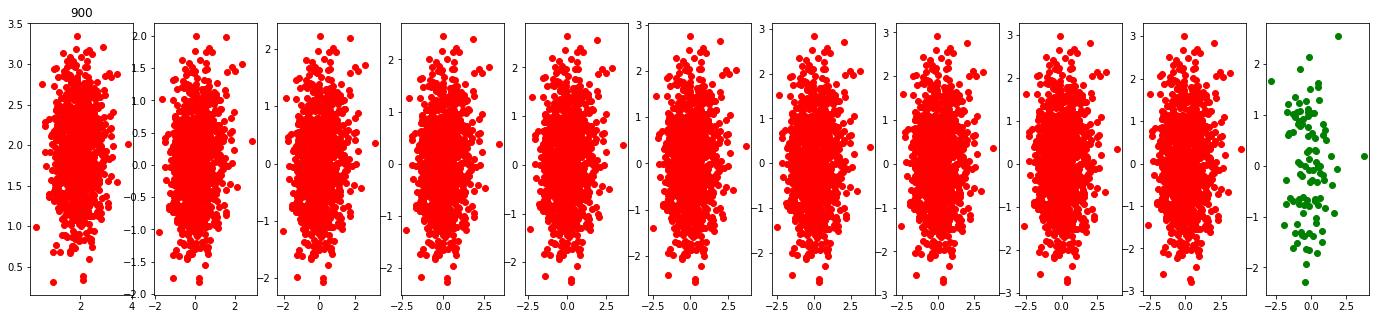

In [28]:
num_particles = len(out["particles"])+1
fig, axes = plt.subplots(1,num_particles, figsize=(24,5))
plot_particles(axes,out)


In [11]:
len(out["particles"][0])

100